In [10]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import torch
import json

In [11]:
from expbasics.network import train_network as train_network, accuracy_per_class
from expbasics.network import train_network
from expbasics.helper import get_attributions, get_dr_methods, get_model_etc, get_centroids
%reload_ext autoreload
%autoreload 2

In [12]:
BIAS = 0.8
model, gm, crp_attribution = get_model_etc(BIAS)

In [13]:
methods, names = get_dr_methods()

In [27]:
pred_vals = gm.intervened_predictions(model)
gm.prediction_flip_new(pred_vals).tolist()

In [5]:
ACTIVATIONS = False
vector, watermarks, predictions, labels = get_attributions(model, ACTIVATIONS, gm, crp_attribution)

In [6]:
vector

tensor([[ 0.1414,  0.0000,  0.0097, -0.2513,  0.3176,  0.2801],
        [ 0.2201,  0.0000,  0.0000, -0.6189,  0.0000,  0.1610],
        [ 0.2073,  0.0600,  0.0000, -0.7012,  0.0078,  0.0238],
        ...,
        [ 0.0138,  0.3362,  0.1339, -0.0446,  0.2902,  0.1814],
        [ 0.0099,  0.3479,  0.1456, -0.0199,  0.3031,  0.1736],
        [ 0.0129,  0.2867,  0.1403, -0.0359,  0.3166,  0.2076]])

torch.Size([230, 2])
torch.Size([268, 2])
torch.Size([2, 2])
torch.Size([265, 2])
torch.Size([235, 2])


Text(0.5, 1.0, 'Bias: 0.8, Relevance: True, Method: Maximum Indices')

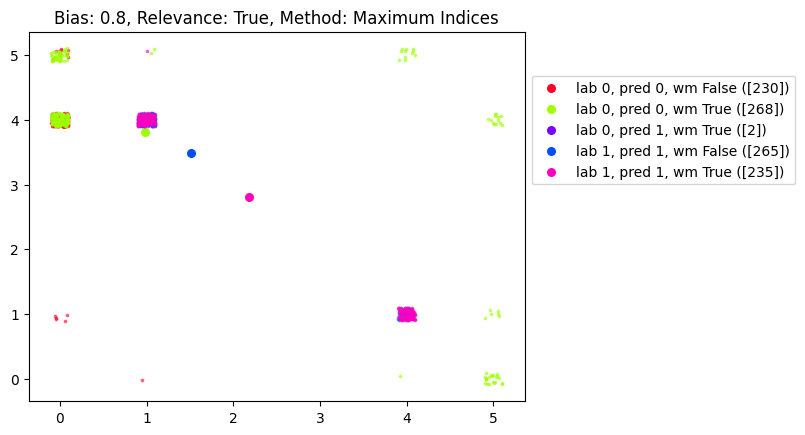

In [7]:
maxs = torch.topk(vector, 2, dim=1)
res = maxs.indices
METHOD = 2
ALPHA = 0.5
colors = mpl.cm.gist_rainbow(np.linspace(0, 1, 8))  # gist_ncar


def ft(lab, wm, pred=None):
    d = np.logical_and(watermarks == wm, labels == lab)
    if pred is not None:
        d = np.logical_and(d, predictions == pred)
    if res[d, 0].shape[0] > 0:
        points = res[d,:] + np.random.uniform(-0.1, 0.1, res[d,:].shape)
        print(res[d,:].shape)
        plt.scatter(
            points[:,0],
            points[:,1],
            s=3,
            color=colors[lab + 2 * wm + 4 * pred],
            alpha=ALPHA,
        )
        meanp = torch.mean(points, dim=0)
        plt.scatter(
            meanp[0],
            meanp[1],
            s=30,
            color=colors[lab + 2 * wm + 4 * pred],
            alpha=1,
            label=f"lab {lab}, pred {pred}, wm {wm == 1} ({[res[d,0].shape[0]]})",
        )


for lab in [0, 1]:
    for wm in [0, 1]:
        for pred in [0, 1]:
            ft(lab, wm, pred)

plt.legend(bbox_to_anchor=(1, 0.9))
plt.title(f"Bias: {BIAS}, Relevance: {not ACTIVATIONS}, Method: Maximum Indices")
# centroids

/home/lilli/.local/lib/python3.10/site-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/lilli/miniconda3/envs/mt/lib/python3.10/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/lilli/miniconda3/envs/mt/lib/python3.10/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/lilli/miniconda3/envs/mt/lib/python3.10/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_

lab 0, pred 0, wm False, (230), median: [ 0.6685191  -0.00316923]
lab 0, pred 1, wm True, (2), median: [-0.4224546  -0.02757164]
lab 0, pred 0, wm True, (268), median: [ 0.65788895 -0.00346494]
lab 1, pred 1, wm False, (265), median: [-0.5609165   0.02550211]
lab 1, pred 1, wm True, (235), median: [-0.5432319  -0.03617783]


Text(0.5, 1.0, 'Bias: 0.8, Activations: False, Method: iso')

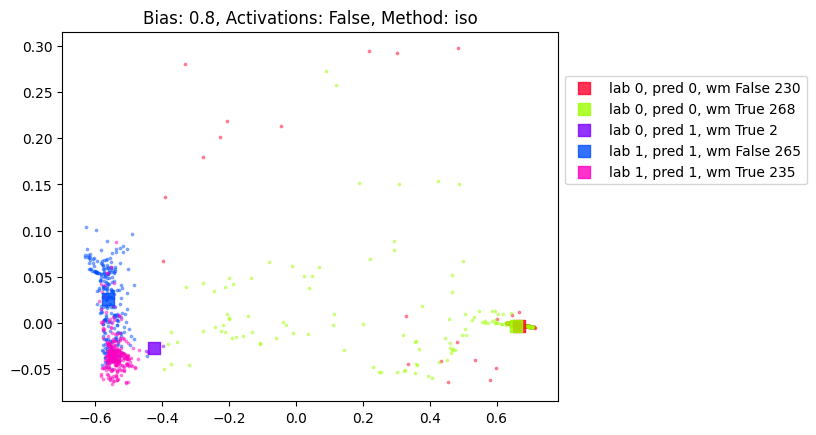

In [9]:
METHOD = 1
#nmf_res = methods[METHOD].fit_transform(vector.numpy())
#res = pca.fit_transform(nmf_res)
res = methods[METHOD].fit_transform(vector.numpy())
#res = res = iso.fit_transform(res)
ALPHA = 0.4

centroids = np.zeros((8, 2))
counts = np.zeros((8), dtype=int)

colors = mpl.cm.gist_rainbow(np.linspace(0, 1, 8))  # gist_ncar


def ft(lab, wm, pred=None):
    d = np.logical_and(watermarks == wm, labels == lab)
    if pred is not None:
        d = np.logical_and(d, predictions == pred)
    if res[d, 0].shape[0] > 0:
        print(
            f"lab {lab}, pred {pred}, wm {wm == 1}, ({res[d,0].shape[0]}), median: {np.median(res[d], 0)}"
        )
        plt.scatter(
            res[d, 0],
            res[d, 1],
            s=3,
            color=colors[lab + 2 * wm + 4 * pred],
            alpha=ALPHA,
        )
        centroids[lab + 2 * wm + 4 * pred] = np.median(res[d], axis=0)
        counts[lab + 2 * wm + 4 * pred] = res[d, 0].shape[0]
    else:
        centroids[lab + 2 * wm + 4 * pred] = np.array([np.nan, np.nan])


ft(0, 0, 1)
ft(0, 0, 0)
ft(0, 1, 1)
ft(0, 1, 0)

ft(1, 0, 1)
ft(1, 0, 0)
ft(1, 1, 1)
ft(1, 1, 0)


for lab in [0, 1]:
    for wm in [0, 1]:
        for pred in [0, 1]:
            if counts[lab + 2 * wm + 4 * pred] > 0:
                plt.scatter(
                    centroids[lab + 2 * wm + 4 * pred, 0],
                    centroids[lab + 2 * wm + 4 * pred, 1],
                    color=colors[lab + 2 * wm + 4 * pred],
                    marker="s",
                    s=70,
                    label=f"lab {lab}, pred {pred}, wm {wm == 1} {counts[lab + 2*wm + 4* pred]}",
                    alpha=0.8
                )

plt.legend(bbox_to_anchor=(1, 0.9))
plt.title(f"Bias: {BIAS}, Activations: {ACTIVATIONS}, Method: {names[METHOD]}")
# centroids

/home/lilli/.local/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


lab 0, wm False, (230), MEAN: [ 0.33580657 -0.31513987]
lab 0, wm True, (270), MEAN: [ 0.26393285 -0.23884841]
lab 1, wm False, (265), MEAN: [-0.30187559  0.2604695 ]
lab 1, wm True, (235), MEAN: [-0.29149085  0.28913541]


Text(0.5, 1.0, 'Bias: 0.8, Activations: False, Method: mds')

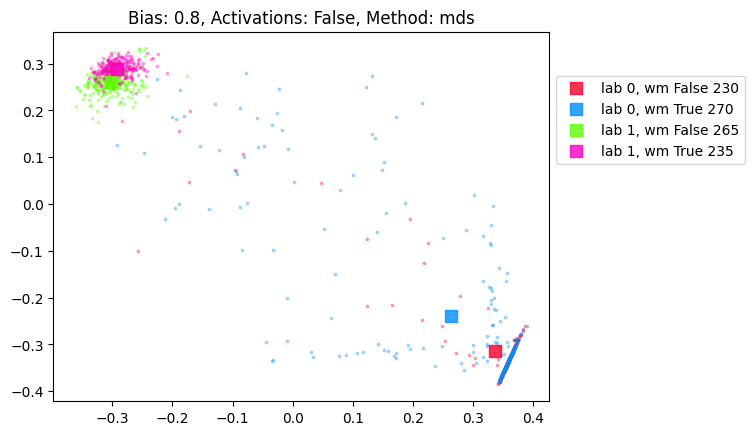

In [14]:
METHOD = 4
res = methods[METHOD].fit_transform(vector.numpy())
ALPHA = 0.3

centroids = np.zeros((4, 2))
counts = np.zeros((4), dtype=int)

colors = mpl.cm.gist_rainbow(np.linspace(0, 1, 4))  # gist_ncar


def ft(lab, wm):
    d = np.logical_and(watermarks == wm, labels == lab)
    if res[d, 0].shape[0] > 0:
        print(
            f"lab {lab}, wm {wm == 1}, ({res[d,0].shape[0]}), MEAN: {np.mean(res[d], 0)}"
        )
        plt.scatter(
            res[d, 0],
            res[d, 1],
            color=colors[lab + 2 * wm],
            alpha=ALPHA,
            s=3,
        )
        centroids[lab + 2 * wm] = np.mean(res[d], axis=0)
        counts[lab + 2 * wm] = res[d, 0].shape[0]
    else:
        centroids[lab + 2 * wm] = np.array([np.nan, np.nan])


ft(0, 0)
ft(0, 1)
ft(1, 0)
ft(1, 1)


for lab in [0, 1]:
    for wm in [0, 1]:
        if counts[lab + 2 * wm] > 0:
            plt.scatter(
                centroids[lab + 2 * wm, 0],
                centroids[lab + 2 * wm, 1],
                color=colors[lab + 2 * wm],
                marker="s",
                s=70,
                label=f"lab {lab}, wm {wm == 1} {counts[lab + 2*wm]}",
                alpha=0.8,
            )

plt.legend(bbox_to_anchor=(1, 0.9))
plt.title(f"Bias: {BIAS}, Activations: {ACTIVATIONS}, Method: {names[METHOD]}")
# centroids

In [94]:
new_centroids = np.zeros((4, 2))

for lab in [0, 1]:
    for wm in [0, 1]:
        d = np.logical_and(watermarks == wm, labels == lab)
        new_centroids[lab + 2 * wm] = np.mean(vector[d], axis=0)
        
new_centroids

TypeError: mean() received an invalid combination of arguments - got (dtype=NoneType, out=NoneType, axis=int, ), but expected one of:
 * (*, torch.dtype dtype)
 * (tuple of ints dim, bool keepdim, *, torch.dtype dtype)
 * (tuple of names dim, bool keepdim, *, torch.dtype dtype)


In [90]:
def compute_distance(centroids):
    a = np.linalg.norm(centroids[0] - centroids[2]) + np.linalg.norm(
        centroids[1] - centroids[3]
    )
    b = np.linalg.norm(centroids[0] - centroids[1]) + np.linalg.norm(
        centroids[2] - centroids[3]
    )
    return a, b, a / b
compute_distance(centroids)

(0.19657071267420717, 2.435652149665069, 0.08070557723164122)

In [92]:
methods, names = get_dr_methods()
ACTIVATIONS = False
METHOD = 1
all_centroids = {}
all_distances = {}

for bias in [0.1,0.3,0.5,0.7,0.9]:
    model, gm, crp_attribution = get_model_etc(bias)
    vector, watermarks, predictions, labels = get_attributions(model, ACTIVATIONS, gm, crp_attribution)
    res = methods[METHOD].fit_transform(vector.numpy())
    centroids = get_centroids(res, watermarks, predictions, labels)
    all_centroids[str(bias)] = centroids
    all_distances[str(bias)] = compute_distance(centroids)

/home/lilli/.local/lib/python3.10/site-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 6 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/lilli/miniconda3/envs/mt/lib/python3.10/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/lilli/miniconda3/envs/mt/lib/python3.10/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/lilli/miniconda3/envs/mt/lib/python3.10/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_

In [93]:
all_distances

{'0.1': (0.020858112256597283, 1.4996085577648683, 0.013909037894319444),
 '0.3': (0.019760491898420704, 1.1596813477873726, 0.017039587586816812),
 '0.5': (0.05035516476788911, 2.032891855595774, 0.024770213245372888),
 '0.7': (0.4124535918235779, 1.8507099747657776, 0.22286235955246161),
 '0.9': (0.5182689941360887, 0.5271356300052057, 0.9831795929464503)}

In [29]:
with open("outputs/tsne_experiment.json", "r") as f: 
    analysis_data = json.load(f)
    
data = sorted(analysis_data.values(), key=lambda x: x["bias"])
experiment = [a["tsne_experiment"] for a in data]
tsne_experiment_no_prediction =  [a["tsne_experiment_no_prediction"] for a in data]
biases = [a["bias"] for a in  data]

In [30]:
labels = []
labels_no_pred = ["", "", "", ""]
for label in [0, 1]:
    for watermark in [0, 1]:
        labels_no_pred[label + 2 * watermark] = f"l:{label} w:{watermark}"
        for prediction in [0, 1]:
            labels.append(f"l:{label} w:{watermark} p:{prediction}")
means = [
    [np.array(a[i]) if i < len(a) else np.zeros(len(a[i])) for i in range(8)]
    for a in experiment  # pca_experiment
]

means_nopred = [[np.array(x) for x in a] for a in tsne_experiment_no_prediction]
labels_no_pred

['l:0 w:0', 'l:1 w:0', 'l:0 w:1', 'l:1 w:1']

Text(0.5, 1.0, 'Mean Euclidean Distance of Centroids')

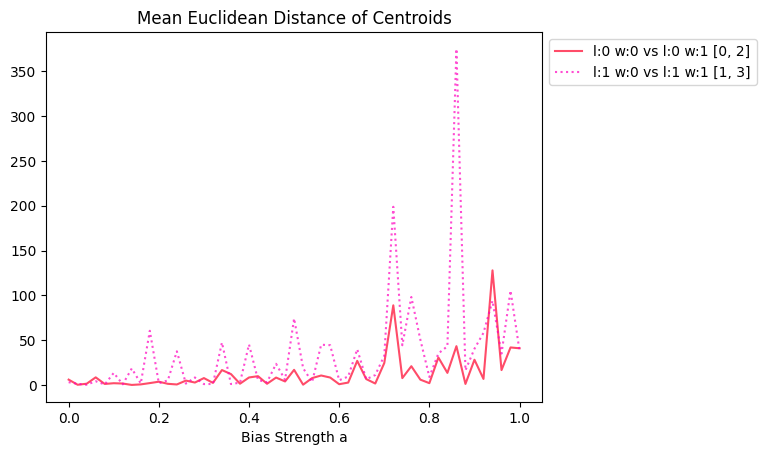

In [31]:
#combis = [[i, j] for i in range(4) for j in range(i + 1, 4)]
combis = [[0,2], [1,3]]
colors = mpl.cm.gist_rainbow(np.linspace(0, 1, len(combis)))  # gist_ncar
styles = ["solid", "dotted", "dashed", "dashdot"]

for x, c in enumerate(combis):
    diff = [np.linalg.norm((m[c[0]]) - (m[c[1]])) for m in means_nopred]
    plt.plot(
        biases,
        diff,
        label=f"{labels_no_pred[c[0]]} vs {labels_no_pred[c[1]]} {c}",
        color=colors[x],
        linestyle=styles[x % len(styles)],
        alpha=0.7
    )


plt.legend(bbox_to_anchor=(1, 1))

plt.xlabel("Bias Strength a")
plt.title("Mean Euclidean Distance of Centroids")